# __Introduction__
---

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

---
## __Data Preprocessing & Exploration__
---

In [82]:
# Importing packages
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV

from IPython.display import display

In [83]:
# Loading dataset
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/insurance_us.csv')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


We'll rename the colums to conform with standard format

In [85]:
# Replacing whitespaces wiht snake cases and converting to lowercase
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [86]:
# Viewing sample 
df.sample(3)

,gender,age,salary,family_members,insurance_benefits
729,0,18.0,40300.0,0,0
3796,0,33.0,60200.0,0,0
2268,1,44.0,28400.0,0,1


In [87]:
# Changing age type 
df['age'] = df['age'].astype('int')

In [88]:
# Confirming changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [89]:
# Checking datasets's measures of location 
df.describe()

,gender,age,salary,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


There are a few outliers within the dataset. We'll identify outliers as 3 standard deviations above the mean. In order to avoid our model learning any bias, we'll eliminate any outliers present.

In [90]:
# Removing outliers
df = df[(np.abs(st.zscore(df) < 3)).all(axis=1)]

In [91]:
# Checking description to confirm changes
df.describe()

,gender,age,salary,family_members,insurance_benefits
count,4814.000000,4814.000000,4814.000000,4814.000000,4814.000000
mean,0.496261,30.344204,39918.861654,1.169090,0.087246
std,0.500038,7.727123,9817.574858,1.039263,0.282224
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33325.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,36.000000,46600.000000,2.000000,0.000000
max,1.000000,49.000000,69400.000000,4.000000,1.000000


---
## __Exploratory Data Analysis__
---

We'll start with a pairplot grid to visualize any trends, correlations, or patterns across paired features.

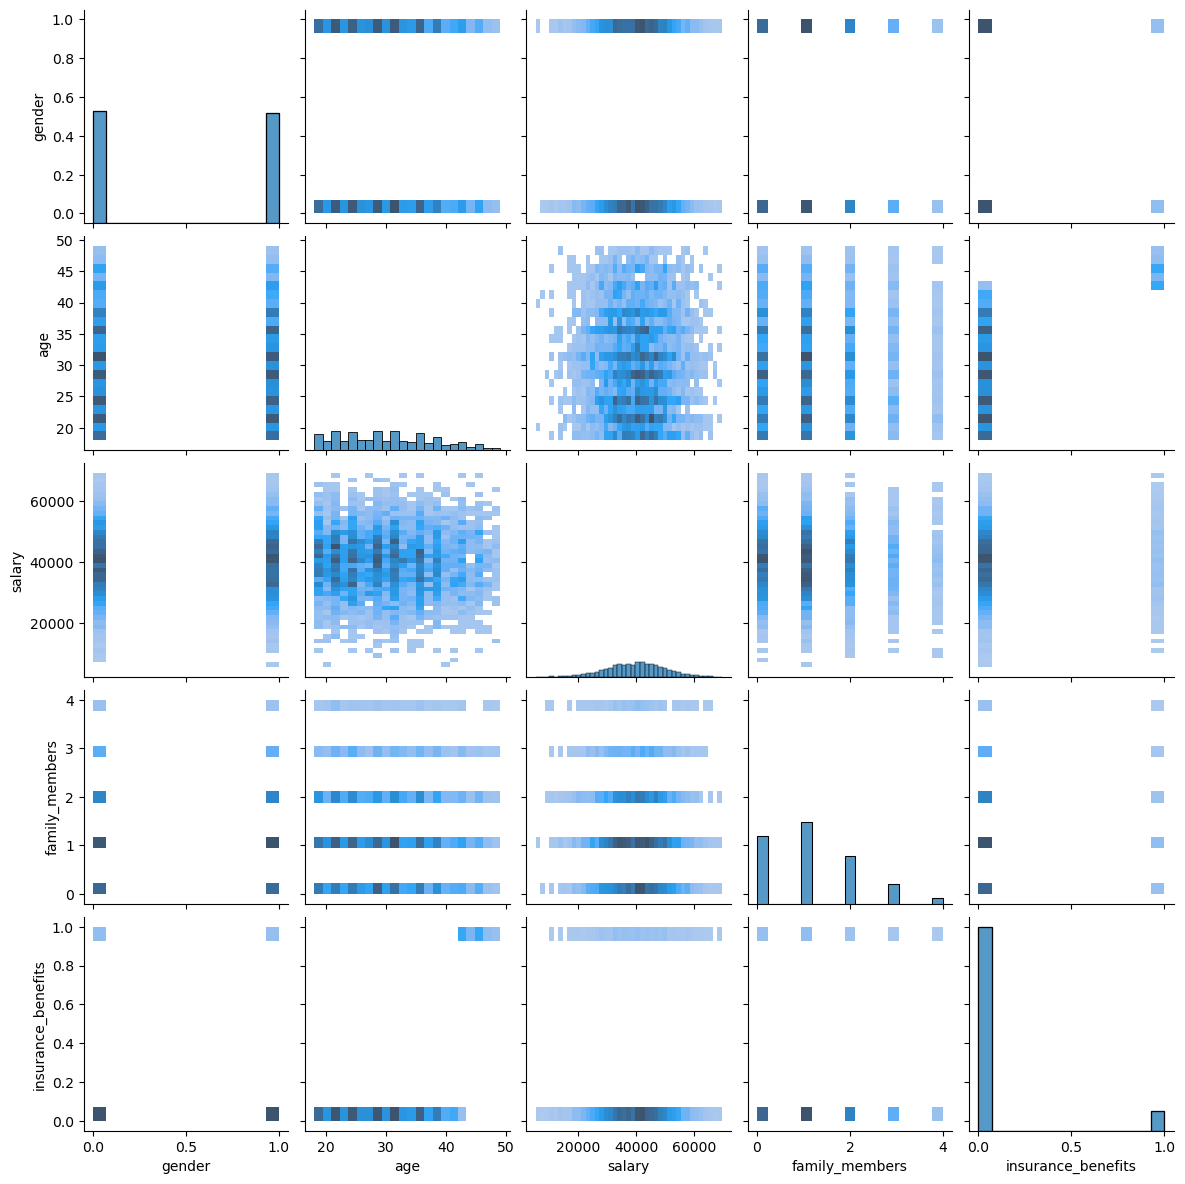

In [92]:
# Plotting pairplot to search for any correlations
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

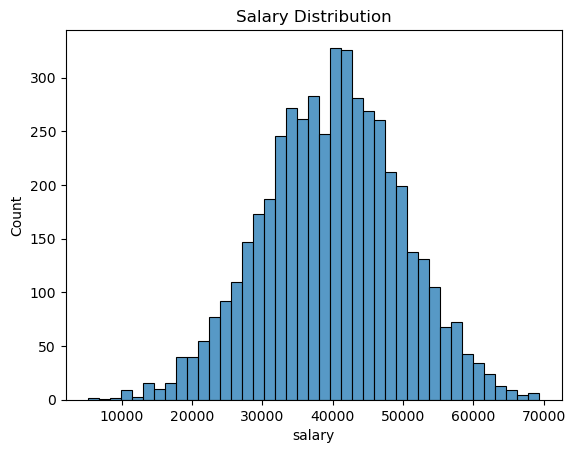

In [93]:
# Plotting income distribution
sns.histplot(df['salary'])
plt.title('Salary Distribution')
plt.show()

The `salary` values have a normal distribution which makes for good data for models to train on. We'll move on to check remaining distributions.

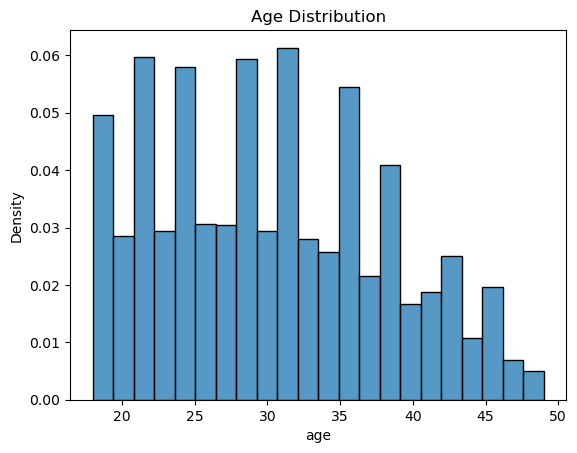

In [94]:
# Plotting age distribution
sns.histplot(df['age'],stat='density')
plt.title('Age Distribution')
plt.show()

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [95]:

def get_knn(df, n, k, metrics):
    
    """
    Returns k nearest neighbors
    
    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    nbrs = sklearn.neighbors.NearestNeighbors(metric = metrics)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    indices = nbrs_indices.flatten()
    distances = nbrs_distances.flatten()
    
    df_res = df.loc[indices][feature_names]
    df_res['distances'] = distances
    
    return df_res

Scaling the data.

In [96]:
df

,gender,age,salary,family_members,insurance_benefits
0,1,41,49600.0,1,0
1,0,46,38000.0,1,1
2,0,29,21000.0,0,0
3,0,21,41700.0,2,0
4,1,28,26100.0,0,0
...,...,...,...,...,...
4995,0,28,35700.0,2,0
4996,0,34,52400.0,1,0
4997,0,20,33900.0,2,0
4998,1,22,32700.0,3,0


In [97]:
feature_names = ['gender', 'age', 'salary', 'family_members']

scaler = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = scaler.transform(df[feature_names].to_numpy())

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_9821/2341285158.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.83673469 0.93877551 0.59183673 ... 0.40816327 0.44897959 0.57142857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = scaler.transform(df[feature_names].to_numpy())
/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_9821/2341285158.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.25 0.   ... 0.5  0.75 0.25]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = scaler.transform(df[feature_names].to_numpy())


In [98]:
df_scaled.sample(5,random_state=12345)

,gender,age,salary,family_members,insurance_benefits
4149,1,0.632653,0.368876,0.00,0
4702,0,0.673469,0.485591,0.50,0
2047,0,0.897959,0.765130,0.50,1
2418,0,0.571429,0.808357,0.00,0
411,1,0.489796,0.474063,0.25,0


In [99]:
df.sample(5,random_state=12345)

,gender,age,salary,family_members,insurance_benefits
4149,1,31,25600.0,0,0
4702,0,33,33700.0,2,0
2047,0,44,53100.0,2,1
2418,0,28,56100.0,0,0
411,1,24,32900.0,1,0


Now, let's get similar records for a given one for every combination

In [100]:
df.loc[2703]

gender                    1.0
age                      34.0
salary                44800.0
family_members            1.0
insurance_benefits        0.0
Name: 2703, dtype: float64

In [101]:
get_knn(df,4149,4,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.000000
2703,1,34,44800.0,1,3.162278
4218,0,41,54800.0,1,3.316625
292,0,32,47200.0,1,3.605551


In [102]:
# Calling knn function to compare difference in distance by metric 
get_knn(df,4149,4,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.000000
2703,1,34,44800.0,1,3.162278
4218,0,41,54800.0,1,3.316625
292,0,32,47200.0,1,3.605551


In [103]:
get_knn(df,4149,4,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.000000
2703,1,34,44800.0,1,3.162278
4218,0,41,54800.0,1,3.316625
292,0,32,47200.0,1,3.605551


In [104]:
get_knn(df,4149,4,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.000000
2703,1,34,44800.0,1,3.162278
4218,0,41,54800.0,1,3.316625
292,0,32,47200.0,1,3.605551


In [105]:
get_knn(df,4149,4,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.000000
2703,1,34,44800.0,1,3.162278
4218,0,41,54800.0,1,3.316625
292,0,32,47200.0,1,3.605551


In [106]:
get_knn(df,4149,4,'manhattan')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,31,25600.0,0,0.0
2703,1,34,44800.0,1,4.0
19,1,27,36900.0,0,5.0
292,0,32,47200.0,1,5.0


In [107]:
# Running scaled features through knn function to compare with non scaled
get_knn(df_scaled,4149,4,'manhattan')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
4149,1,0.632653,0.368876,0.00,0.000000
2692,0,0.816327,0.451009,0.25,0.034817
7,1,0.510204,0.556196,1.00,0.044904
3145,0,0.530612,0.586455,1.00,0.050668


In [108]:
# Calling function with different object to confirm previous observations
get_knn(df,2047,5,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
2047,0,44,53100.0,2,0.000000
3124,1,22,50300.0,1,1.414214
1464,0,36,40500.0,2,1.414214
1316,0,35,21200.0,0,1.732051
1176,1,27,46100.0,1,2.236068


In [109]:
get_knn(df,2047,5,'manhattan')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
2047,0,44,53100.0,2,0.0
1464,0,36,40500.0,2,2.0
3124,1,22,50300.0,1,2.0
1176,1,27,46100.0,1,3.0
1316,0,35,21200.0,0,3.0


In [110]:
get_knn(df_scaled,2047,5,'euclidean')

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,distances
2047,0,0.897959,0.765130,0.50,0.000000
2613,1,0.469388,0.412104,0.00,0.005764
4037,1,0.918367,0.671470,0.50,0.007205
1111,1,0.734694,0.481268,0.00,0.023055
1245,0,0.714286,0.651297,0.25,0.024982


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

__Answer__: The data being not scaled affects the knn algorithm. We can see by the nearest neighbor selections. The euclidean and manhattan metric selections has same indexes selected for 5 nearest neighbors with the non scaled data. Different nearest neighbors were selected when using the scaled data. 

We wouldn't know which one is more accurate without setting a target with a measurement of accuracy but can say the scaling of data affects the knn algotrithm.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

__Answer__: The manhattan metric produced an average of 50% higher distances that of the euclidean metric, using the non scaled data.. Both metrics resulted in the same observations as nearest neighbors but manhattan distances was higher on each observation, and all round numbers as well. The manhattan metric is be less sensitive to outliers as euclidean distances takes the squared distances between the vectors.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [111]:
# Converting target column to binary values
df['insurance_benefits_received'] = [1 if x > 0 else 0 for x in df['insurance_benefits']]
df_scaled['insurance_benefits_received'] = [1 if x > 0.0 else 0 for x in df_scaled['insurance_benefits']]

In [112]:
# Checking for class imbalance
print(df['insurance_benefits_received'].value_counts())
print(df_scaled['insurance_benefits_received'].value_counts())

insurance_benefits_received
0    4394
1     420
Name: count, dtype: int64
insurance_benefits_received
0    4394
1     420
Name: count, dtype: int64


In a project where performance is prioritized, we would want to handle this class imbalance by increasing positive instances and/or decreasing the negative instances to minimize model bias. This project doesn't prioritize model performance so we'll just move on from here.

In [113]:
# Defining function for model evaluation
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [114]:
# Function to generate simulationo of random output for baseline

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [115]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df.shape[0], seed=42)# <your code here> 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.91275447 0.        ]
 [0.08724553 0.        ]]

The probability: 0.09
F1: 0.10
Confusion Matrix
[[0.83236394 0.08039053]
 [0.07852098 0.00872455]]

The probability: 0.50
F1: 0.15
Confusion Matrix
[[0.46240133 0.45035314]
 [0.04486913 0.0423764 ]]

The probability: 1.00
F1: 0.16
Confusion Matrix
[[0.         0.91275447]
 [0.         0.08724553]]



We'll use these dummy model scores as a barometer to evaluate our models' intelligence.

In [116]:
# splitting training and test features without scaling to check performance and compare with scaled training data
X = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
y = df['insurance_benefits_received']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=12345)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3369, 4) (3369,)
(1445, 4) (1445,)


In [117]:
# Creating GridsearchCV to produce f1 scores for range of kneighbor values
params = {
    'n_neighbors' : np.arange(1,11,1),
    'metric' : ['euclidean']
}

lin_class = sklearn.neighbors.KNeighborsClassifier()

lin_cv = GridSearchCV(
    lin_class,
    param_grid = params,
    verbose = 3,
    scoring = 'f1',
    refit = False
)

In [118]:
lin_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=1;, score=0.479 total time=   0.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=1;, score=0.473 total time=   0.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=1;, score=0.435 total time=   0.0s
[CV 4/5] END ...metric=euclidean, n_neighbors=1;, score=0.478 total time=   0.0s
[CV 5/5] END ...metric=euclidean, n_neighbors=1;, score=0.422 total time=   0.0s
[CV 1/5] END ...metric=euclidean, n_neighbors=2;, score=0.067 total time=   0.0s
[CV 2/5] END ...metric=euclidean, n_neighbors=2;, score=0.232 total time=   0.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=2;, score=0.246 total time=   0.0s
[CV 4/5] END ...metric=euclidean, n_neighbors=2;, score=0.127 total time=   0.0s
[CV 5/5] END ...metric=euclidean, n_neighbors=2;, score=0.286 total time=   0.0s
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.092 total time=   0.0s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             refit=False, scoring='f1', verbose=3)

In [119]:
lin_df = pd.DataFrame(lin_cv.cv_results_,columns=['param_n_neighbors','params','mean_test_score','rank_test_score']).sort_values("rank_test_score")

In [120]:
lin_df

,param_n_neighbors,params,mean_test_score,rank_test_score
0,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.457510,1
2,3,"{'metric': 'euclidean', 'n_neighbors': 3}",0.218402,2
1,2,"{'metric': 'euclidean', 'n_neighbors': 2}",0.191481,3
4,5,"{'metric': 'euclidean', 'n_neighbors': 5}",0.085913,4
3,4,"{'metric': 'euclidean', 'n_neighbors': 4}",0.073235,5
6,7,"{'metric': 'euclidean', 'n_neighbors': 7}",0.034370,6
5,6,"{'metric': 'euclidean', 'n_neighbors': 6}",0.027707,7
7,8,"{'metric': 'euclidean', 'n_neighbors': 8}",0.000000,8
8,9,"{'metric': 'euclidean', 'n_neighbors': 9}",0.000000,8
9,10,"{'metric': 'euclidean', 'n_neighbors': 10}",0.000000,8


As the above DataFrame shows, as the number of kneighbors increases the f1 score generally decreases when using our unscaled data to train this model. Let's run our test set through the model to see how it scores.

In [121]:
# Running test set through model
lin_class = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1, metric = 'euclidean')
lin_class.fit(X_train, y_train)
predictions = lin_class.predict(X_test)
score = sklearn.metrics.f1_score(y_test,predictions)
print(f'F1 score: {score:.2f}')

F1 score: 0.58


Not a great score but outperformed the dummy models' scores. Still not a great performance from this model. I expect using scaled data will improve the model's score by a lot.

In [122]:
# Scaling data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MaxAbsScaler was fitted without feature names
  warnings.warn(
/Users/User2/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MaxAbsScaler was fitted without feature names
  warnings.warn(


In [123]:
lin_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=1;, score=0.897 total time=   0.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=1;, score=0.916 total time=   0.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=1;, score=0.955 total time=   0.0s
[CV 4/5] END ...metric=euclidean, n_neighbors=1;, score=0.875 total time=   0.0s
[CV 5/5] END ...metric=euclidean, n_neighbors=1;, score=0.943 total time=   0.0s
[CV 1/5] END ...metric=euclidean, n_neighbors=2;, score=0.860 total time=   0.0s
[CV 2/5] END ...metric=euclidean, n_neighbors=2;, score=0.882 total time=   0.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=2;, score=0.893 total time=   0.0s
[CV 4/5] END ...metric=euclidean, n_neighbors=2;, score=0.854 total time=   0.0s
[CV 5/5] END ...metric=euclidean, n_neighbors=2;, score=0.845 total time=   0.0s
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.838 total time=   0.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             refit=False, scoring='f1', verbose=3)

In [124]:
lin_scaled_df = pd.DataFrame(lin_cv.cv_results_, columns = ['param_n_neighbors','params','mean_test_score','rank_test_score'])

In [125]:
lin_scaled_df

,param_n_neighbors,params,mean_test_score,rank_test_score
0,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.917287,1
1,2,"{'metric': 'euclidean', 'n_neighbors': 2}",0.867057,5
2,3,"{'metric': 'euclidean', 'n_neighbors': 3}",0.890115,4
3,4,"{'metric': 'euclidean', 'n_neighbors': 4}",0.854719,8
4,5,"{'metric': 'euclidean', 'n_neighbors': 5}",0.892703,3
5,6,"{'metric': 'euclidean', 'n_neighbors': 6}",0.860884,6
6,7,"{'metric': 'euclidean', 'n_neighbors': 7}",0.892854,2
7,8,"{'metric': 'euclidean', 'n_neighbors': 8}",0.839594,9
8,9,"{'metric': 'euclidean', 'n_neighbors': 9}",0.855743,7
9,10,"{'metric': 'euclidean', 'n_neighbors': 10}",0.814704,10


Using our scaled data to train this model, we can see the odd numbered inputs of kneighber from range 1-10 are higher than its neighboring even inputs in their respective scores output. Their f1 scores show the model has done a good job detecting trends within the training set. Let'see how it does in with the test set predictions.

In [126]:
# Running test set through model trained with scaled data
lin_class.fit(X_train,y_train)
predictions = lin_class.predict(X_test)
score = sklearn.metrics.f1_score(y_test,predictions)
print(f'F1 score using scaled data: {score:.2f}')

F1 score using scaled data: 0.94


The model using the scaled data scored a perfect f1 score than when non scaled data was used, not to mention performing much better than the dummy models.

The f1 scores on the training and test sets show scaling the data has a very positive impact on a model's performance.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated target (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [127]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)# <your code here>

    def predict(self, X):
        
        # adding the unities
        X2 = np.append((np.ones([len(X), 1])), X, axis=1) # <your code here>
        y_pred = X.dot(self.weights) # <your code here>
        
        return y_pred

In [128]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')

In [129]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print("Weights:",lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test,y_test_pred)
print("Predictions:\n", y_test_pred[:3])

Weights: [-0.04395221  0.60229806 -0.39317875 -0.08968139]
RMSE: 0.26
R2: 0.49
Predictions:
 [0.19205927 0.16986463 0.19516564]


In [130]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print("Weights: ", lr.weights[:])

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)
print("Predictions:\n",y_test_pred[:5])

Weights:  [-0.04395221  0.60229806 -0.39317875 -0.08968139]
RMSE: 0.26
R2: 0.49
Predictions:
 [0.19205927 0.16986463 0.19516564 0.02634138 0.04223892]


The results for both scaled and unscaled data appear to be identical. I believe it is due the algorithm's ability to assign optimal weights to both scaled and unscaled feature sets.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [131]:
# Declaring calumns to obfuscate values
personal_info_column_list = ['gender', 'age', 'salary', 'family_members']
df_pn = df[personal_info_column_list]

In [132]:
X = df_pn.to_numpy()

In [133]:
X[0]

array([1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00])

Generating a random matrix $P$.

In [134]:
# Instantiating random number generator to generate P key
rng = np.random.default_rng(seed=42)

# Genreating matrix P as key
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [135]:
inv_P = np.linalg.inv(P)
inv_P

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can the customers' ages or income be guessed after the transformation?

In [136]:
X_obf = X.dot(P)
X_obf

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

__Answer__: There's practically no way to guess the customers' age or income looking at the obfuscated data. No real way to distinguish any of the values displayed above.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [137]:
# Recovering data from obfuscation using the inverted P key
recovered_data = X_obf.dot(inv_P)

__Answer__: We are able to recover a matrix close to the original data after reverting the obfuscated matrix by multiplying the obfuscated matrix by the inverted P matrix. It is not an exact match, as shown below.

In [138]:
print('Original data: \n\n',df_pn.head(3))
print('\nObfucated data: \n\n',X_obf[:3])
print('\nRecovered data: \n\n',recovered_data[:3])

Original data: 

    gender  age   salary  family_members
0       1   41  49600.0               1
1       0   46  38000.0               1
2       0   29  21000.0               0

Obfucated data: 

 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]

Recovered data: 

 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

__Answer__: Some of the values are not exact possibly because operations in the numpy library introduce rounding to floating points to a tiny degree. When multiplying using these rounded floats, it will result in a slightly different value than the original

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w$ and $w_P$ are linked by $P$. $w_P$ can be reverted back to $w$ by using the inversed $P$ matrix

The predicted values with $w_P$ would be values predicted using obfuscated features

If using an obfuscated feature matrix to run predictions, the quality of the linear regression, if measured with RMSE, would remain if the model's weights are adjusted according to $P$. We'll show you with some analytical proof,

**Analytical proof**

Analytical proof measured RSME would not be affected by obfuscation:

Assumptions:
- $\hat{y}$ = $X_w$
- $\hat{y_P}$ = $X_P w_P$
- $w$ = $X^T X)^{-1} X^T y$
- $w_P$ = $[(XP)^T (XP)]^{-1} (XP)^T) y$

Beginning with $w_P$:

$$
w_P = [(XP)^T (XP)]^{-1} (XP)^T) y \quad \Rightarrow \quad w_P = [P^TX^T XP]^{-1} (XP)^T y
$$
$$
w_P = [P^TX^T XP]^{-1} (XP)^T y \quad \Rightarrow \quad w_P = P^{-1}(X^T X)^{-1}(P^T)^{-1}(XP)^T y
$$
$$
w_P = P^{-1}(X^T X)^{-1}(P^T)^{-1} (XP)^T y \quad \Rightarrow \quad w_p = P^{-1}(X^T X)^{-1}(P^T)^{-1} P^TX^T y
$$
$$
w_P = P^{-1}(X^T X)^{-1}(P^T)^{-1} P^TX^T y \quad \Rightarrow \quad w_P = P^{-1}(X^T X)^{-1}IX^T
$$ 
$$
w_P = P^{-1}(X^T X)^{-1}IX^T y \quad \Rightarrow \quad w_P = P^{-1}(X^T X) X^T y
$$
Substitute $w$:
$$
w_p = P^{-1}w
$$

The predicted values generated would be calculated as follows:
$$
\hat{y_P} = X_P w_p \quad \Rightarrow \quad \hat{y_P} = X_P P^{-1}w
$$
$$
\hat{y_P} = XP P^{-1}w \quad \Rightarrow \quad \hat{y} = XI w
$$
$$
\therefore \hat{y_P} \implies \hat{y}
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Obfuscate model weights using P matrix
- Use $XP$ as the new feature matrix

In [140]:
X = df[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

In [141]:
# Creating square matrix P of random numbers
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(X.shape[1],X.shape[1]))

In [142]:
# Inverting P
inv_P = np.linalg.inv(P)
P

array([[0.22733602, 0.31675834, 0.79736546, 0.67625467],
       [0.39110955, 0.33281393, 0.59830875, 0.18673419],
       [0.67275604, 0.94180287, 0.24824571, 0.94888115],
       [0.66723745, 0.09589794, 0.44183967, 0.88647992]])

In [143]:
# Obfuscating feature matrix
X_obf = X.dot(P)
X_obf

array([[33379.07890705, 46726.83792118, 12346.7195778 , 47093.30478654],
       [25575.85436704, 35803.17566182,  9470.45780663, 36089.47796444],
       [14134.46966896, 19787.04616252,  5236.28360548, 19946.11557395],
       ...,
       [22812.31108745, 31933.64409532,  8432.36071442, 32182.3691004 ],
       [22006.51685368, 30804.54288554,  8137.1007362 , 31046.13744165],
       [27321.31914263, 38246.49427533, 10102.14239519, 38544.58310932]])

Features are unrecognizable from original data

In [144]:
# Testing and scoring unobfuscated data
y_pred = lr.predict(X)
r2 = sklearn.metrics.r2_score(y,y_pred)
mse = sklearn.metrics.mean_squared_error(y,y_pred)
rmse = mse ** 0.5
print('Unobfuscated r2 score :', r2)
print('Unobfuscate RSME: ',rmse)

Unobfuscated r2 score : -3280974089.977855
Unobfuscate RSME:  16164.042586933198


In [145]:
# Recalibrating model weights to adjust to obfuscated out-of-bag data
lr.weights = np.linalg.inv(X.dot(P).T.dot(X.dot(P))).dot(X.dot(P).T).dot(y)

In [146]:
# Passing obfuscated data through model as new features for testing
y_pred = lr.predict(X_obf)
r2 = sklearn.metrics.r2_score(y,y_pred)
mse = sklearn.metrics.mean_squared_error(y,y_pred)
rmse = mse ** 0.5
print('R2 score using obfuscated features:',r2)
print('RMSE results using obfuscated features:',rmse)

R2 score using obfuscated features: 0.221386696555251
RMSE results using obfuscated features: 0.2490058185736492


RMSE and R2 scores using obfuscated data match the scores using unobfuscated feature. This proves RMSE nor R2 score are not affected by data obfuscation using an invertable P matrix as long as the weights are adjusted according to $P$.

# Conclusions

In conclusion there is much vualue in the tools we've used in our project as shown in the results of our experiments/tests.

The kNN algorithm showed how effective it is in helping trained models predict targets from new features. This could help many businesses across many sectors in evaluating new investments, customers, etc. This can be a very useful tool but as we saw on Task 2; the higher k value in the n_neighbors hyperparameter, the less accurate the predictions get.

Here we also see that feature scaling allows for the model to properly assess a wider range of values without features with much high values than others to overly influence results/weights. We saw the scores get exponentially better using scaled data vs the raw data. Feature preprocessing must include feature scaling/normilization when features' difference in values are high enough to skew the algorithm.

Data obfuscation is a necesssary tool to preserve customer/client privacy. Data leaks happen often and any measure to protect data should always be implemented, including data obfuscation, making, etc. Some measures are better than others but in this project we used an invertable matrix to linearly transform data in such a way to make it unrecognizable to the reader. This is an effective way to preserve data security while not affecting the results of our experiments when addressed appropriately. One important thing to keep in mind is the obfuscated data can remain secure if the $P$ key is kept secret and not lost.